## Gated Recurrent Unit (GRU)

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Helper functions
from helper_functions import get_bitcoin_df, create_dataset_with_look_back

# Needed imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [30]:
# Get the dataframe
btc_df = get_bitcoin_df()
btc_df.head()

,date,open,high,low,close,volume_btc,volume_usd
0,2017-01-01,977.256602,977.385233,977.132620,977.276060,4.760662,4701.831942
1,2017-01-02,1012.267604,1012.517181,1011.988826,1012.273903,5.671792,5747.243606
2,2017-01-03,1020.001535,1020.226840,1019.794437,1020.040472,6.312263,6442.176792
3,2017-01-04,1076.558840,1077.271167,1075.572542,1076.553639,14.973928,16303.129214
4,2017-01-05,1043.608646,1044.905549,1042.094125,1043.547951,25.013098,25132.509465


In [31]:
# Select data range
bitcoin_dataframe = btc_df[(btc_df['date'] < '2022-02-01') & (btc_df['date'] > '2019-12-31')]

## Non-Stationary data

In [32]:
# Prepare data
univariate_df = bitcoin_dataframe[['date', 'close']].copy()

close_only_df = univariate_df.filter(['close'])
dataset = close_only_df.values

scaler = MinMaxScaler(feature_range=(0, 1))
# We shouldn't do this as we leak information about test dataset
#scaled_data = scaler.fit_transform(dataset)

In [33]:
# Define train and test size
train_size = int(0.7 * len(univariate_df))
test_size = len(univariate_df) - train_size

# Set look back
look_back = 30

train_unscaled, test_unscaled = dataset[:train_size-look_back, :], dataset[train_size-look_back:, :]
train_scaled = scaler.fit_transform(train_unscaled)
test_scaled = scaler.transform(test_unscaled)

x_train, y_train = create_dataset_with_look_back(train_scaled, look_back)
x_test, y_test = create_dataset_with_look_back(test_scaled, look_back)

# Reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print("Train size: ", len(x_train), " test size: ", len(x_test))

Train size:  473  test size:  229


In [34]:
# Building the model
model = Sequential()
model.add(GRU(32, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train, y_train, epochs=200, batch_size=32)

model.summary()

Epoch 1/200
15/15 [==============================] - 6s 33ms/step - loss: 0.0462
Epoch 2/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0060
Epoch 3/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0023
Epoch 4/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0016
Epoch 5/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0014
Epoch 6/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0013
Epoch 7/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0012
Epoch 8/200
15/15 [==============================] - 0s 29ms/step - loss: 0.0011
Epoch 9/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0011
Epoch 10/200
15/15 [==============================] - 0s 29ms/step - loss: 0.0010
Epoch 11/200
15/15 [==============================] - 0s 29ms/step - loss: 9.6534e-04
Epoch 12/200
15/15 [==============================] - 0s 28ms/step - loss: 9.3053e-04
Epoch 13/200
15/1

In [35]:
# Do predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate the scores
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
score_r2 = r2_score(y_test[0], test_predict[:, 0])
print('RMSE: {}, R2: {}'.format(score_rmse, score_r2))

8/8 [==============================] - 0s 7ms/step
RMSE: 1382.2328751582882, R2: 0.9786214251519869


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

ValueError: array length 129 does not match index length 100

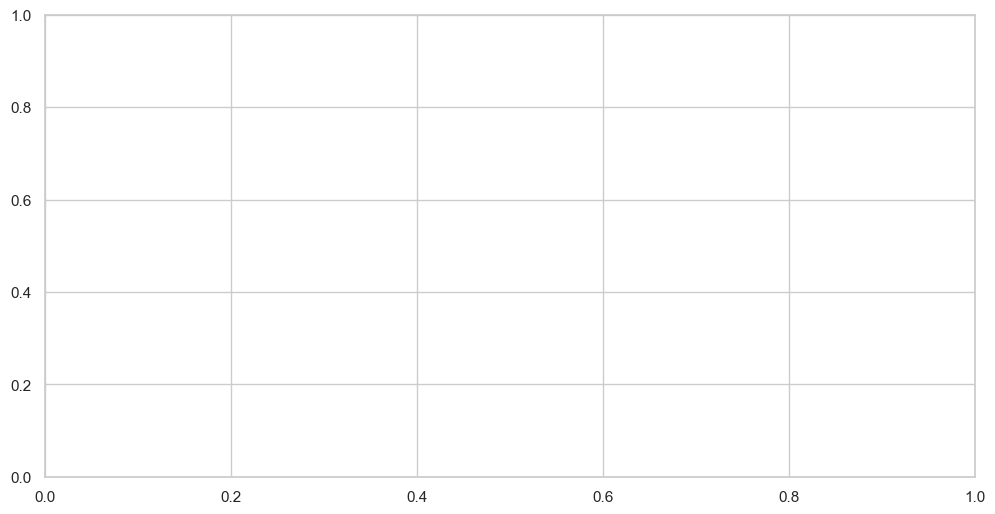

In [45]:
x_train_ticks = univariate_df.head(train_size)['date']
y_train = univariate_df.head(train_size)['close']
x_test_ticks = univariate_df.tail(test_size)['date']

fig, ax = plt.subplots(1, figsize=(12, 6))
sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, color=sns.color_palette("muted")[0], label='Train Set', alpha=0.7, linewidth=1.3)
sns.lineplot(x=x_train_ticks[look_back:-look_back], y=train_predict[:, 0], ax=ax, color=sns.color_palette("muted")[3], label='Train Prediction')
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color=sns.color_palette("muted")[1], label='Ground truth', alpha=0.7, linewidth=1.3)
sns.lineplot(x=x_test_ticks, y=test_predict[:, 0], ax=ax, color=sns.color_palette("muted")[2], label='Prediction')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}, R2: {score_r2:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Close', fontsize=14)

### Stationary data

In [38]:
# Prepare data
univariate_df = bitcoin_dataframe[['date', 'close']].copy()

# 1st order differencing
univariate_df['close_diff_1'] = np.append([0], np.diff(univariate_df['close']))

close_only_df = univariate_df.filter(['close_diff_1'])
dataset = close_only_df.values

scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = scaler.fit_transform(dataset)

In [39]:
# Define train and test size
train_size = int(0.7 * len(univariate_df))
test_size = len(univariate_df) - train_size

# Set look back
look_back = 30

train_unscaled, test_unscaled = dataset[:train_size-look_back, :], dataset[train_size-look_back:, :]
train_scaled = scaler.fit_transform(train_unscaled)
test_scaled = scaler.transform(test_unscaled)

x_train, y_train = create_dataset_with_look_back(train_scaled, look_back)
x_test, y_test = create_dataset_with_look_back(test_scaled, look_back)

# Reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print("Train size: ", len(x_train), " test size: ", len(x_test))

Train size:  473  test size:  229


In [40]:
# Building the model
model = Sequential()
model.add(GRU(32, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train, y_train, epochs=200, batch_size=32)

model.summary()

Epoch 1/200
15/15 [==============================] - 7s 34ms/step - loss: 0.1231
Epoch 2/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0179
Epoch 3/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0099
Epoch 4/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0082
Epoch 5/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0079
Epoch 6/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0081
Epoch 7/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0080
Epoch 8/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0080
Epoch 9/200
15/15 [==============================] - 0s 29ms/step - loss: 0.0080
Epoch 10/200
15/15 [==============================] - 0s 30ms/step - loss: 0.0080
Epoch 11/200
15/15 [==============================] - 0s 29ms/step - loss: 0.0081
Epoch 12/200
15/15 [==============================] - 0s 29ms/step - loss: 0.0080
Epoch 13/200
15/15 [=====

In [41]:
# Do predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate the scores
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
score_r2 = r2_score(y_test[0], test_predict[:, 0])
print('RMSE: {}, R2: {}'.format(score_rmse, score_r2))

8/8 [==============================] - 0s 7ms/step
RMSE: 1359.7909948546185, R2: -0.025629759971994348


/var/folders/5d/h_8336656hb0sql9hqtn3m400000gn/T/ipykernel_63092/2646127335.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.lineplot(x=x_train_ticks[look_back:-look_back], y=train_predict[:, 0], ax=ax, color=sns.color_palette("muted")[3], label='Train Prediction')


Text(0, 0.5, 'Close (1st Order Differencing)')

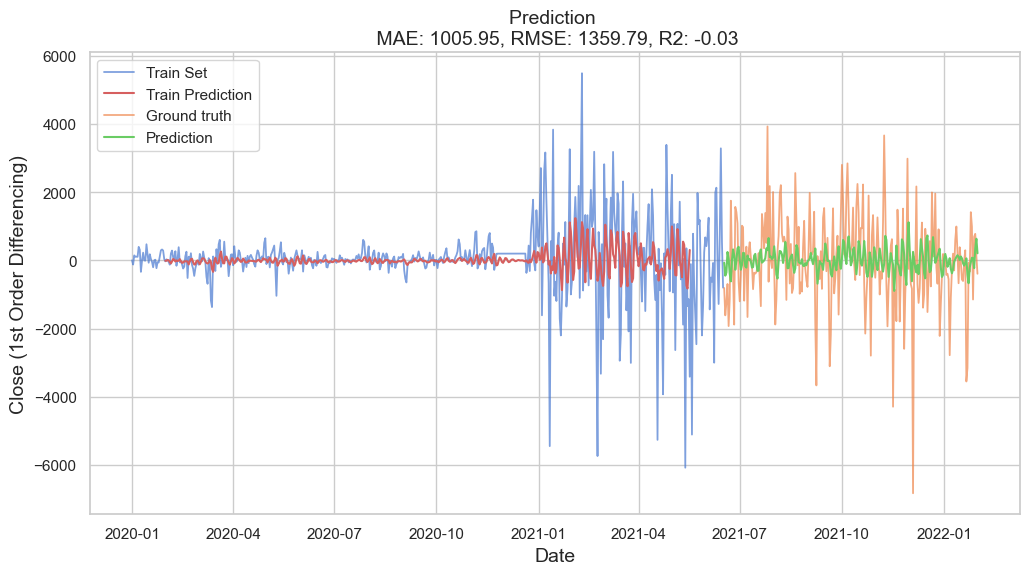

In [42]:
x_train_ticks = univariate_df.head(train_size)['date']
y_train = univariate_df.head(train_size)['close_diff_1']
x_test_ticks = univariate_df.tail(test_size)['date']

fig, ax = plt.subplots(1, figsize=(12, 6))
sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, color=sns.color_palette("muted")[0], label='Train Set', alpha=0.7, linewidth=1.3)
sns.lineplot(x=x_train_ticks[look_back:-look_back], y=train_predict[:, 0], ax=ax, color=sns.color_palette("muted")[3], label='Train Prediction')
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color=sns.color_palette("muted")[1], label='Ground truth', alpha=0.7, linewidth=1.3)
sns.lineplot(x=x_test_ticks, y=test_predict[:, 0], ax=ax, color=sns.color_palette("muted")[2], label='Prediction')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}, R2: {score_r2:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Close (1st Order Differencing)', fontsize=14)

GRU also fails on Stationary data even though it performs well on Non-Stationary data